# LFD and HFD Preprocessing Example for Data Descriptor

#### Purpose: This notebook serves to demenostrate our preprocessing pipeline of both our LFD & HFD raw data and integration with enviromental factors and social determinatnts of health

In [2]:
import os 
import pathlib
import sys
os.chdir("..")
# # 1) 取得專案根目錄 (Notebook 的上一層)
# project_root = pathlib.Path.cwd().parent

# # 2) 加到 sys.path（放到前面，確保優先找到）
# project_root_str = str(project_root.resolve())
# if project_root_str not in sys.path:
#     sys.path.insert(0, project_root_str)

In [3]:
#%pip install boto3
from PY_FILES import daily_script_LFD_ds
from PY_FILES import daily_AG_HFD_time_fix_ds
#import mariadb
import pandas as pd
import numpy as np
import scipy as sp
import datetime as DT
import boto3
import json
import collections
#import bson
import datetime
import os
from os.path import isfile, join
import io
from io import StringIO
from meteostat import Point, Daily
import warnings
from pprint import pprint
warnings.filterwarnings('ignore')

#%tb

## Creating the LFD Tables from the Raw CSV Files

#### There are four data tables that we create from four raw CSV files

#### 1. Breacumbs table - contains the periodic data as measured on the data loggers (NOTE: all direct and indirect identifiers such as the trip start and end addresses and GPS coordinates have been removed for privacy reasons)

#### 2. Activities table - provides detailed trip information by breaking down fuel usage, MPG, number of stops, distance traveled, and driving behavior (i.e., hard-braking, speeding, idling, sudden acceleration) for each vehicle

#### 3. Events table - provides detailed information on all adverse events (i.e., hard braking, hard acceleration, speeding) at a vehicle level per trip (cite Sayeh's paper)

#### 4. Summary table - contains aggregates of all daily trips carried out by each vehicle

#### For this demonstration, we'll be using the raw breadcrumbs, activity, summary, and events csv files collect on March 15, 2023


In [4]:
# Loading in the raw csv files from the raw_data folder
breadcrumbs = pd.read_csv('./raw_data/Breadcrumb_15Mar2023.csv', index_col = False)
activities = pd.read_csv('./raw_data/Activity_15Mar2023.csv', index_col = False)
summaries = pd.read_csv('./raw_data/Summary_15Mar2023.csv', index_col = False)
events = pd.read_csv('./raw_data/Events_15Mar2023.csv', index_col = False)


In [5]:
# Quality checking the csv files just loaded in
breadcrumbs.head()

,vehicleId,vehicleName,driverId,driverName,groupId,groupName,occupants,vehicleSpeed,speedLimit,difference,...,offset,odometerReading,distanceTravelled,tripNumber,tripDistance,gpsFixQuality,peakSpeed,averageSpeed,initialSpeed,finalSpeed
0,00d6fab0-fa4f-11e9-a3ec-b9a07413ca83,9010985002,NaN,NaN,e338fa22-f31d-11e3-b62f-0b73e5561466,Default Group,NaN,0.0,NaN,NaN,...,-300,10444.0,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN
1,00d6fab0-fa4f-11e9-a3ec-b9a07413ca83,9010985002,NaN,NaN,e338fa22-f31d-11e3-b62f-0b73e5561466,Default Group,NaN,0.0,NaN,NaN,...,-300,10444.0,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN
2,00d6fab0-fa4f-11e9-a3ec-b9a07413ca83,9010985002,NaN,NaN,e338fa22-f31d-11e3-b62f-0b73e5561466,Default Group,NaN,0.0,NaN,NaN,...,-300,10444.0,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN
3,00d6fab0-fa4f-11e9-a3ec-b9a07413ca83,9010985002,NaN,NaN,e338fa22-f31d-11e3-b62f-0b73e5561466,Default Group,NaN,0.0,NaN,NaN,...,-300,10444.0,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN
4,00d6fab0-fa4f-11e9-a3ec-b9a07413ca83,9010985002,NaN,NaN,e338fa22-f31d-11e3-b62f-0b73e5561466,Default Group,NaN,0.0,NaN,NaN,...,-300,10444.0,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN


#### For better interpretability, we create a Date column that provides the date in YYYY-MM-DD format for each file. This is useful when aggregating multiple datasets

In [6]:
# Performing some data manipulations on the LFD data

# Converting the trip start & event times into datatime objects and creating a Date column for each dataset
activities['tripStartDate'] = pd.to_datetime(activities['tripStartDate'])
breadcrumbs['eventTime'] = pd.to_datetime(breadcrumbs['eventTime'])
summaries['tripDate'] = pd.to_datetime(summaries['tripDate'])
events['eventTime'] = pd.to_datetime(events['eventTime'])

activities['Date'] = activities['tripStartDate'].dt.date
breadcrumbs['Date'] = breadcrumbs['eventTime'].dt.date
summaries['Date'] = summaries['tripDate'].dt.date
events['Date'] = events['eventTime'].dt.date

#### To process these raw files, we use functions that transforms all four tables into finalized tables that can be used in subsequent analyses. These functions are imported from the daily_script_LFD_ds.py script in the PY_FILES folder.

In [7]:
import importlib
importlib.reload(daily_script_LFD_ds)

df_Act=pd.DataFrame()
LFD_trip_info=pd.DataFrame()
df_gps_final=pd.DataFrame()
df_Events_final=pd.DataFrame()
df_Impacts_final=pd.DataFrame()

# Processing the Activity file
tmp = daily_script_LFD_ds.Activity_info(activities,LFD_trip_info)
if tmp is not None:
     LFD_trip_info = pd.concat([LFD_trip_info, tmp], axis=0)
        
# Processing the Summary File
df_Impacts_final = daily_script_LFD_ds.impact_info(summaries, df_Impacts_final)

# Processing the Breadcrumbs File
df_gps_final = daily_script_LFD_ds.Breadcrumb_info(breadcrumbs,df_gps_final)

# Processing the Breadcrumbs file
df_Events_final = daily_script_LFD_ds.Events_info(events, df_Events_final)

In [8]:
# Quality Checking the data tables that were just created
#LFD_trip_info.dropna(subset=['participantId'], inplace=True)
LFD_trip_info.head()

,vehicleName,groupId,groupName,occupants,tripStartTime,tripStartOffset,tripEndTime,tripEndOffset,stopTime,distanceTravelled,...,averageSpeed,fuelConsumed,Date,beaconDetected,beaconIssued,tripLocalStartDate,tripLocalStartTime,weekNumber,tripLocalEndDate,tripLocalEndTime
0,1062503094,e338fa22-f31d-11e3-b62f-0b73e5561466,Default Group,NaN,2023-03-15 17:27:25+00:00,-300,2023-03-15 17:38:09,-300,692.0,5.16,...,37.90,0.000,2023-03-15,1,NaN,2023-03-15,12:27:25,429,2023-03-15,12:38:09
1,1062503948,e338fa22-f31d-11e3-b62f-0b73e5561466,Default Group,NaN,2023-03-15 17:27:27+00:00,-300,2023-03-15 17:34:21,-300,3577.0,4.60,...,44.12,0.151,2023-03-15,1,NaN,2023-03-15,12:27:27,429,2023-03-15,12:34:21
2,1062503354,e338fa22-f31d-11e3-b62f-0b73e5561466,Default Group,NaN,2023-03-15 17:27:50+00:00,-300,2023-03-15 17:51:07,-300,309.0,14.04,...,38.53,0.000,2023-03-15,1,NaN,2023-03-15,12:27:50,429,2023-03-15,12:51:07
3,1112903039,e338fa22-f31d-11e3-b62f-0b73e5561466,Default Group,NaN,2023-03-15 17:28:09+00:00,-300,2023-03-15 17:51:20,-300,9498.0,6.71,...,33.55,0.318,2023-03-15,1,NaN,2023-03-15,12:28:09,429,2023-03-15,12:51:20
4,20485032,e338fa22-f31d-11e3-b62f-0b73e5561466,Default Group,NaN,2023-03-15 17:28:31+00:00,-300,2023-03-15 17:49:50,-300,447.0,6.46,...,26.10,0.248,2023-03-15,1,NaN,2023-03-15,12:28:31,429,2023-03-15,12:49:50


In [9]:
print(df_gps_final.columns.tolist())

['vehicleId', 'vehicleName', 'driverId', 'driverName', 'groupId', 'groupName', 'occupants', 'vehicleSpeed', 'speedLimit', 'difference', 'eventName', 'eventType', 'tripStateId', 'eventTime', 'timeoffset', 'odometerReading', 'distanceTravelled', 'tripNumber', 'tripDistance', 'gpsFixQuality', 'peakSpeed', 'averageSpeed', 'initialSpeed', 'finalSpeed', 'Date', 'gsDate', 'weekNo', 'monthNo']


## Creating the HFD tables from Raw JSON Files

#### There are four data tables that we create for each JSON file corresponding to a trip taken by a vehicle.

#### 1. trip_info table - contains the data that are collected at periodic 1-second intervals along with the accelerometer and gyroscope data at 24 Hz (NOTE: all direct and indirect identifiers such as the trip start and end addresses and GPS coordinates have been removed for privacy reasons)

#### 2. Activity table - provides detailed trip information by breaking down fuel usage, MPG, number of stops, distance traveled, and driving behavior (i.e., hard-braking, speeding, idling, sudden acceleration) for each vehicle (cite Sayeh's paper)

#### 3. Braking table - provides detailed information on all hard and hardcore braking events per vehicle per trip

#### 4. idling table - provides detailed information on all idling events (i.e. where a participant turns on their vehicle but doesn't drive) per vehicle per trip 

#### For this demonstration, we'll be processing a single JSON file pertaining to a trip that was taken by a participant on March 31, 2023

In [10]:
%%time
trip_info = pd.DataFrame()
activity = pd.DataFrame()
braking = pd.DataFrame()
idling = pd.DataFrame()

importlib.reload(daily_AG_HFD_time_fix_ds)
# this data are placed in .tar.gz files
file = './raw_data/March_2023_jsons_week_4/1070303381_2023_03_31_3167.json'
hfd_info = daily_AG_HFD_time_fix_ds.insert_data(file)

trip_info = pd.DataFrame(hfd_info['trip_info'])
activity = pd.DataFrame(hfd_info['Activity'])
braking = pd.DataFrame(hfd_info['braking'])
idling = pd.DataFrame(hfd_info['idling'])

CPU times: total: 19.7 s
Wall time: 20 s


In [11]:
# Quality Checking the data tables that were just created
trip_info.head()

,vehicleName,tripNumber,tripStartTime,tripEndTime,tripOffset,recordTime,eventTime,localDateVal,localTimeVal,AX1,...,GX24,GY24,GZ24,gpsSpeed,heading,satellites,fixQuality,hDOP,Engine_RPM,Vehicle_speed
0,1070303381,3167,2023-03-31 20:36:23,2023-03-31 20:56:23,-300.0,1.680295e+12,2023-03-31 20:36:24,2023-03-31,15:36:24,0.015625,...,-0.4725,0.4725,0.0,0.0,0.0,7.0,3.0,0.0,791.0,0
1,1070303381,3167,2023-03-31 20:36:23,2023-03-31 20:56:23,-300.0,1.680295e+12,2023-03-31 20:36:25,2023-03-31,15:36:25,0.015625,...,-0.4725,0.4725,0.0,0.0,0.0,7.0,3.0,0.0,792.0,0
2,1070303381,3167,2023-03-31 20:36:23,2023-03-31 20:56:23,-300.0,1.680295e+12,2023-03-31 20:36:26,2023-03-31,15:36:26,0.015625,...,0.0000,0.0000,0.0,0.0,0.0,7.0,3.0,0.0,793.0,0
3,1070303381,3167,2023-03-31 20:36:23,2023-03-31 20:56:23,-300.0,1.680295e+12,2023-03-31 20:36:27,2023-03-31,15:36:27,0.015625,...,0.0000,0.0000,0.0,0.0,0.0,7.0,3.0,0.0,812.0,0
4,1070303381,3167,2023-03-31 20:36:23,2023-03-31 20:56:23,-300.0,1.680295e+12,2023-03-31 20:36:28,2023-03-31,15:36:28,0.015625,...,0.0000,0.0000,0.0,0.0,0.0,7.0,3.0,0.0,803.0,0


## Merging the Clinical & Neuropsych Data 

#### Once you have the LFD and HFD processed, you are able to then merge data from external sources into these tables in order to build more comprehensive tables that represent participants' naturalistic driving behavior in relation to cognitive decline

#### One such example is merging in the participants' cinical data with their LFD. Once created, users can run subsequent analyses examining the associations between our participants naturalistic driving data and their cognitive substrates

In [12]:
# reading in the participant clinical and neuropsyc data file from the raw_data folde
clinical_neuropsych = pd.read_csv('./raw_data/participant_clinical_and_neuropsyc_data.csv', index_col=False)

clinical_neuropsych.head()

,vehicleName,chip1_install_date,trail_a,trail_b,srt_free_recall,animals,number_of_medications,cdrsum,cdrglobal
0,1062501461,2022-03-17,37.0,71.0,29.0,25.0,6.0,1.0,0.5
1,1062601004,2022-04-06,46.0,150.0,25.0,16.0,9.0,2.0,0.5
2,2201503362,2022-06-16,35.0,116.0,31.0,29.0,2.0,1.5,0.5
3,9100485057,2020-02-13,NaN,NaN,22.0,27.0,NaN,2.0,0.5
4,80102573,2021-06-28,29.0,62.0,21.0,18.0,3.0,0.0,0.0


In [13]:
# merging the clinical data into the LFD using the chip ID
# happy > paticipantId not exist?
# org: LFD_trip_info['participantId'] = LFD_trip_info['participantId'].astype(int)
# happy: since it is merge by vehicleName, change from participantId to vehicleName
LFD_trip_info['vehicleName'] = LFD_trip_info['vehicleName'].astype(int)
LFD_with_clinical = LFD_trip_info.merge(clinical_neuropsych, on='vehicleName')

LFD_with_clinical.head()

,vehicleName,groupId,groupName,occupants,tripStartTime,tripStartOffset,tripEndTime,tripEndOffset,stopTime,distanceTravelled,...,tripLocalEndDate,tripLocalEndTime,chip1_install_date,trail_a,trail_b,srt_free_recall,animals,number_of_medications,cdrsum,cdrglobal
0,1112903039,e338fa22-f31d-11e3-b62f-0b73e5561466,Default Group,NaN,2023-03-15 17:28:09+00:00,-300,2023-03-15 17:51:20,-300,9498.0,6.71,...,2023-03-15,12:51:20,2022-05-18,37.0,77.0,31.0,24.0,10.0,0.5,0.0
1,1113004460,e338fa22-f31d-11e3-b62f-0b73e5561466,Default Group,NaN,2023-03-15 17:31:09+00:00,-300,2023-03-15 17:40:15,-300,481.0,3.11,...,2023-03-15,12:40:15,2022-04-14,32.0,119.0,14.0,20.0,20.0,1.0,0.5
2,1031201755,e338fa22-f31d-11e3-b62f-0b73e5561466,Default Group,NaN,2023-03-15 17:32:46+00:00,-300,2023-03-15 17:36:21,-300,1466.0,0.56,...,2023-03-15,12:36:21,2021-09-16,48.0,68.0,30.0,26.0,18.0,0.0,0.0
3,1112902864,e338fa22-f31d-11e3-b62f-0b73e5561466,Default Group,NaN,2023-03-15 17:34:32+00:00,-300,2023-03-15 17:41:31,-300,3086.0,2.24,...,2023-03-15,12:41:31,2023-03-08,29.0,109.0,7.0,13.0,5.0,2.0,0.5
4,2201501305,e338fa22-f31d-11e3-b62f-0b73e5561466,Default Group,NaN,2023-03-15 17:37:32+00:00,-300,2023-03-15 17:42:38,-300,2145.0,1.24,...,2023-03-15,12:42:38,2022-06-23,44.0,259.0,35.0,19.0,5.0,1.5,0.5


# Happy Test: Merge with HFD

# Conclusion > merge on vehiclename but not patient name

In [14]:
trip_info['vehicleName'] = trip_info['vehicleName'].astype(int)
trip_info = trip_info.merge(clinical_neuropsych, on='vehicleName')

trip_info.head()

,vehicleName,tripNumber,tripStartTime,tripEndTime,tripOffset,recordTime,eventTime,localDateVal,localTimeVal,AX1,...,Engine_RPM,Vehicle_speed,chip1_install_date,trail_a,trail_b,srt_free_recall,animals,number_of_medications,cdrsum,cdrglobal
0,1070303381,3167,2023-03-31 20:36:23,2023-03-31 20:56:23,-300.0,1.680295e+12,2023-03-31 20:36:24,2023-03-31,15:36:24,0.015625,...,791.0,0,2021-10-20,26.0,42.0,33.0,21.0,15.0,1.0,0.5
1,1070303381,3167,2023-03-31 20:36:23,2023-03-31 20:56:23,-300.0,1.680295e+12,2023-03-31 20:36:25,2023-03-31,15:36:25,0.015625,...,792.0,0,2021-10-20,26.0,42.0,33.0,21.0,15.0,1.0,0.5
2,1070303381,3167,2023-03-31 20:36:23,2023-03-31 20:56:23,-300.0,1.680295e+12,2023-03-31 20:36:26,2023-03-31,15:36:26,0.015625,...,793.0,0,2021-10-20,26.0,42.0,33.0,21.0,15.0,1.0,0.5
3,1070303381,3167,2023-03-31 20:36:23,2023-03-31 20:56:23,-300.0,1.680295e+12,2023-03-31 20:36:27,2023-03-31,15:36:27,0.015625,...,812.0,0,2021-10-20,26.0,42.0,33.0,21.0,15.0,1.0,0.5
4,1070303381,3167,2023-03-31 20:36:23,2023-03-31 20:56:23,-300.0,1.680295e+12,2023-03-31 20:36:28,2023-03-31,15:36:28,0.015625,...,803.0,0,2021-10-20,26.0,42.0,33.0,21.0,15.0,1.0,0.5


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Experiment 1: dealing with LFD: LFD_with_clinical

In [16]:
observed_Dataset = LFD_with_clinical
# show the columns
# print(LFD_with_clinical.columns)
# show the data type 
# since we will need the time information > how to convert
print(LFD_with_clinical.dtypes)
numeric_cols = LFD_with_clinical.select_dtypes(include=['number']).columns
numeric_cols = list(numeric_cols)
# observed_Dataset = observed_Dataset[numeric_cols]
print(len(numeric_cols))

vehicleName                            int64
groupId                               object
groupName                             object
occupants                             object
tripStartTime            datetime64[ns, UTC]
tripStartOffset                        int64
tripEndTime                   datetime64[ns]
tripEndOffset                          int64
stopTime                             float64
distanceTravelled                    float64
tripNumber                             int64
tripTime                               int64
idleTime                             float64
hardBrakingCount                       int64
hardCoreBrakingCount                   int64
hardAccelerationCount                  int64
overspeedingCount                    float64
overspeedingDuration                 float64
corneringCount                         int64
maximumSpeed                         float64
averageSpeed                         float64
fuelConsumed                         float64
Date      

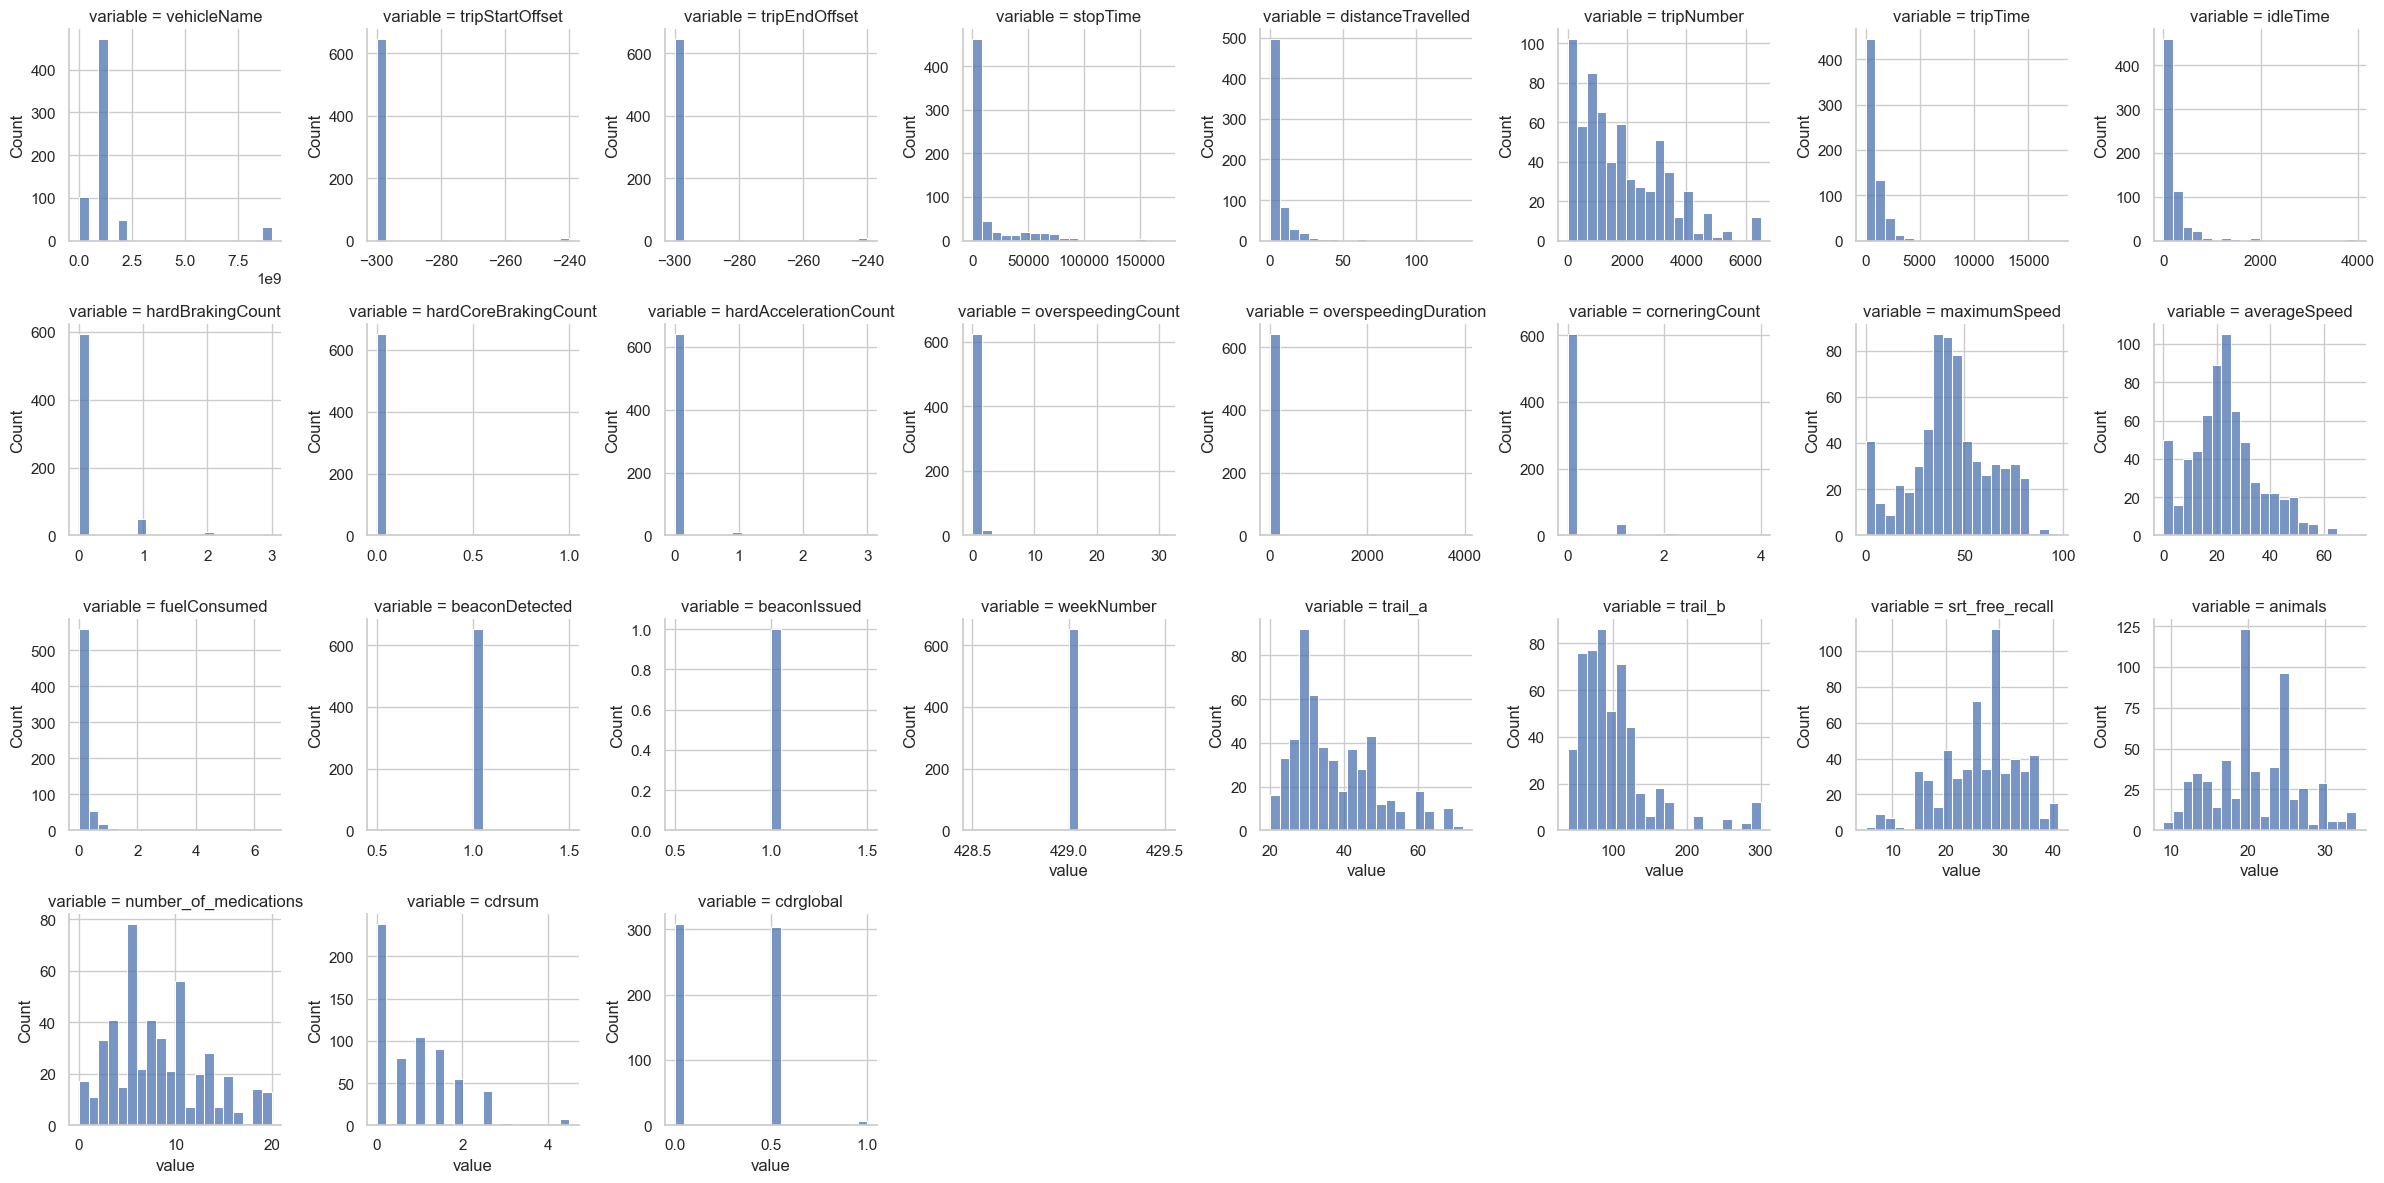

In [17]:
import seaborn as sns
sns.set_theme(style="whitegrid")
%matplotlib inline
# visualization with numerical datas
df_melted = observed_Dataset[numeric_cols].melt(var_name="variable", value_name="value")
g = sns.FacetGrid(df_melted, col="variable", col_wrap=8, sharex=False, sharey=False)
g.map(sns.histplot, "value", bins=20)
plt.show()

# Experiment 2: Dealing with HFD: trip_info

vehicleName                       int64
tripNumber                       object
tripStartTime            datetime64[us]
tripEndTime              datetime64[us]
tripOffset                      float64
                              ...      
srt_free_recall                 float64
animals                         float64
number_of_medications           float64
cdrsum                          float64
cdrglobal                       float64
Length: 168, dtype: object
159


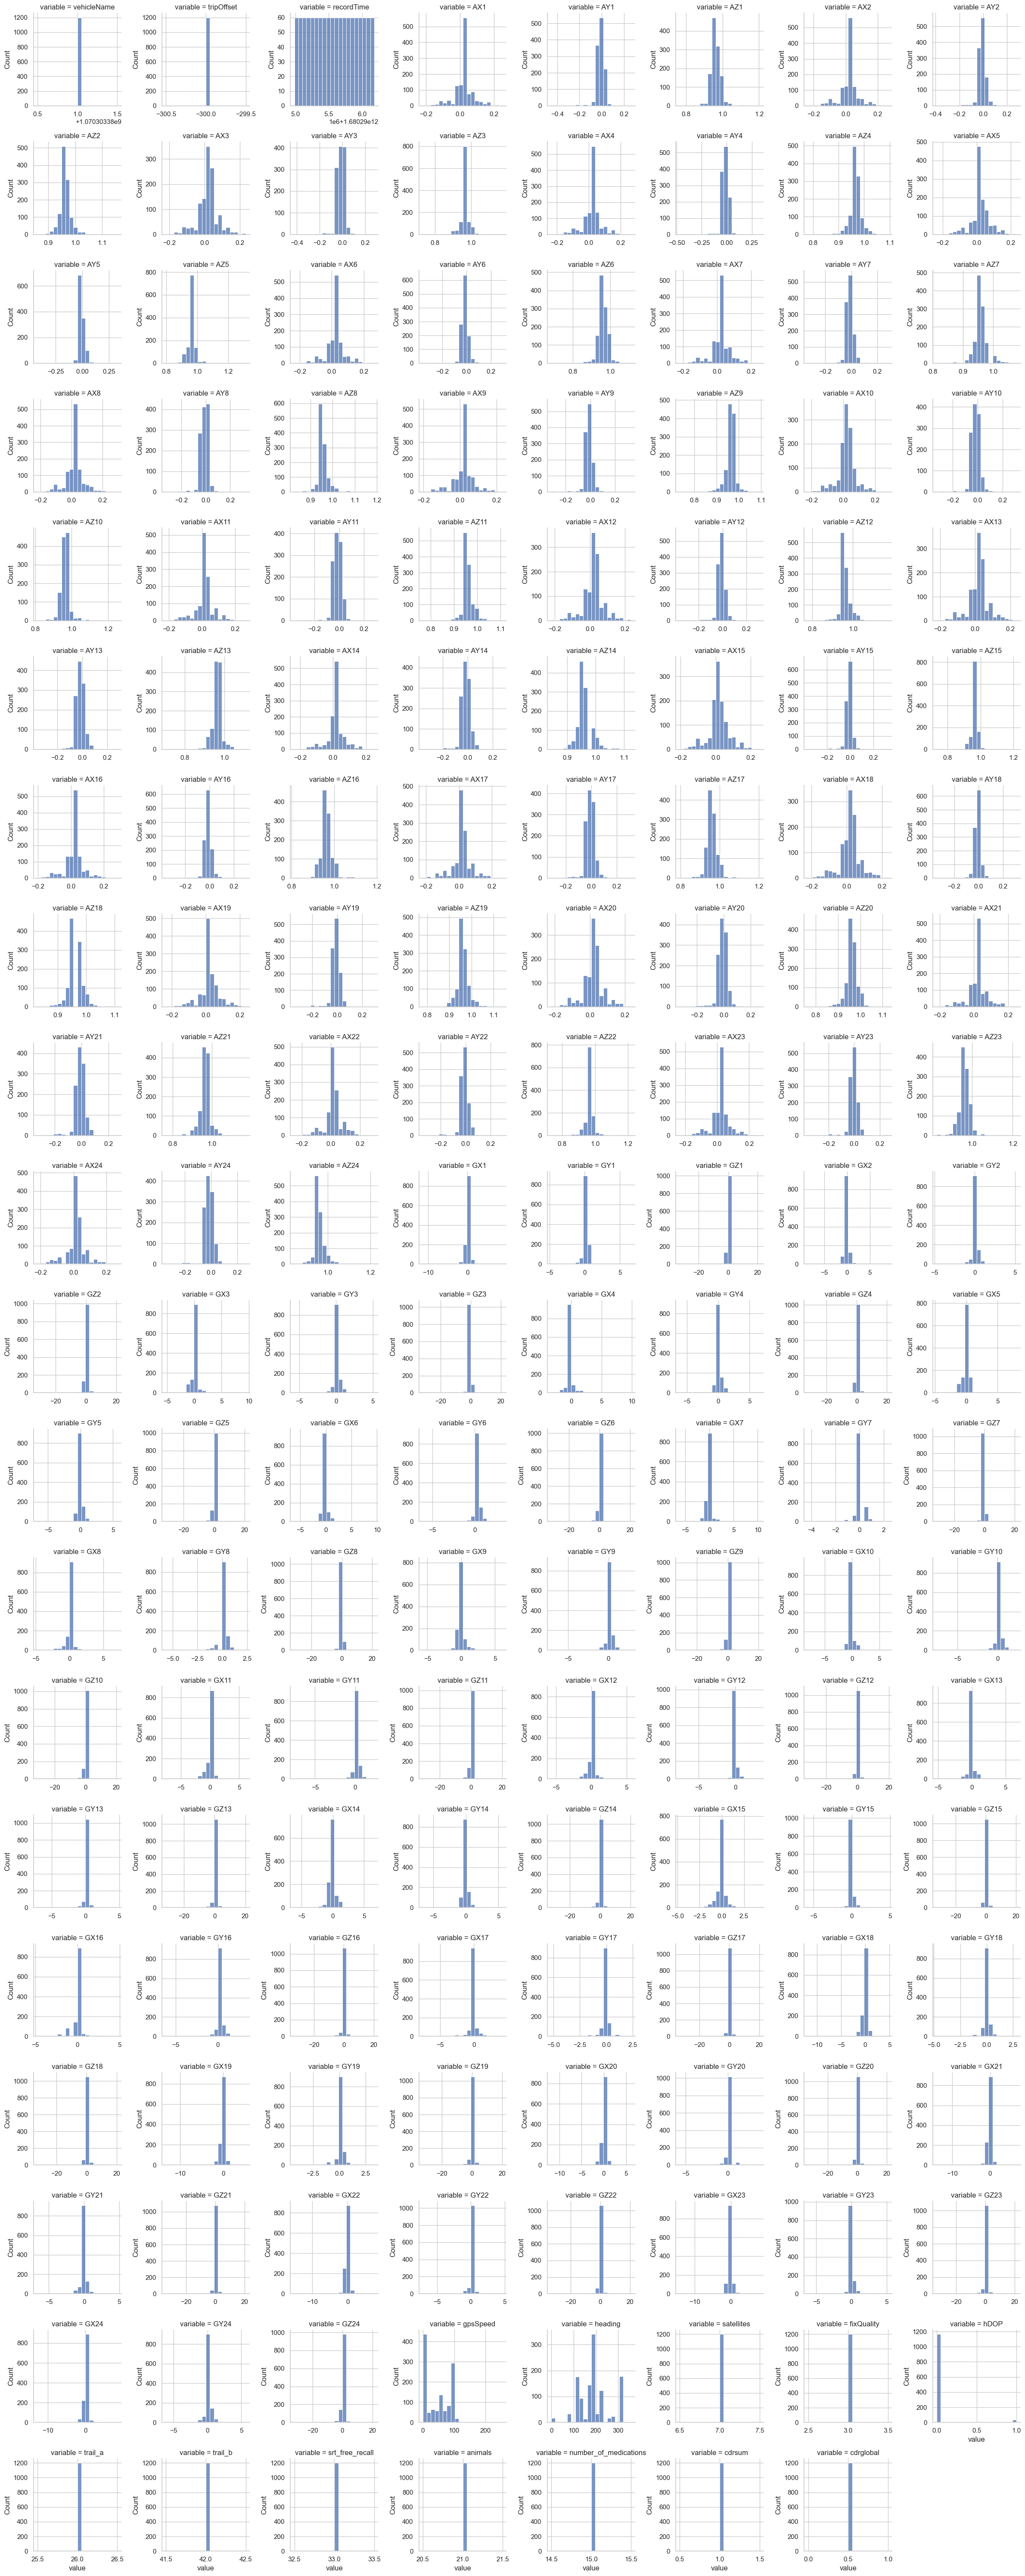

In [18]:
observed_Dataset = trip_info
# show the columns
# print(LFD_with_clinical.columns)
# show the data type 
# since we will need the time information > how to convert
print(trip_info.dtypes)
numeric_cols = trip_info.select_dtypes(include=['number']).columns
numeric_cols = list(numeric_cols)
# observed_Dataset = observed_Dataset[numeric_cols]
print(len(numeric_cols))

import seaborn as sns
sns.set_theme(style="whitegrid")
%matplotlib inline
# visualization with numerical datas
df_melted = observed_Dataset[numeric_cols].melt(var_name="variable", value_name="value")
g = sns.FacetGrid(df_melted, col="variable", col_wrap=8, sharex=False, sharey=False)
g.map(sns.histplot, "value", bins=20)
plt.show()